# US Treasury vs ECB Yield Curves Methodology

This notebook compares:

- A US-style curve: bootstrapped discount factors and forwards from bond **prices**, with monotone-convex interpolation on forwards, then par yields.
- An ECB-style curve: Nelson–Siegel–Svensson (NSS) zero-coupon curve **fitted directly to market bond yields** implied by the same prices, then par yields.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

np.set_printoptions(precision=8, suppress=True)

## 1. Synthetic Input Data

In practice, you would pull the actual US **on‑the‑run set**; here we define a simple example.

In [2]:
# Synthetic on-the-run style input; replace with actual prices if desired
instruments = pd.DataFrame([
    {"maturity": 4/52, "type": "bill", "price": 99.10, "coupon": 0.0, "freq": 1},
    {"maturity": 13/52, "type": "bill", "price": 97.50, "coupon": 0.0, "freq": 1},
    {"maturity": 26/52, "type": "bill", "price": 95.00, "coupon": 0.0, "freq": 1},
    {"maturity": 2.0, "type": "bond", "price": 101.20, "coupon": 0.045, "freq": 2},
    {"maturity": 3.0, "type": "bond", "price": 102.00, "coupon": 0.041, "freq": 2},
    {"maturity": 5.0, "type": "bond", "price": 99.50, "coupon": 0.038, "freq": 2},
    {"maturity": 7.0, "type": "bond", "price": 98.20, "coupon": 0.038, "freq": 2},
    {"maturity": 10.0, "type": "bond", "price": 96.70, "coupon": 0.039, "freq": 2},
    {"maturity": 20.0, "type": "bond", "price": 95.00, "coupon": 0.041, "freq": 2},
    {"maturity": 30.0, "type": "bond", "price": 93.50, "coupon": 0.040, "freq": 2},
]).sort_values("maturity").reset_index(drop=True)

instruments

,maturity,type,price,coupon,freq
0,0.076923,bill,99.1,0.000,1
1,0.250000,bill,97.5,0.000,1
2,0.500000,bill,95.0,0.000,1
3,2.000000,bond,101.2,0.045,2
4,3.000000,bond,102.0,0.041,2
5,5.000000,bond,99.5,0.038,2
6,7.000000,bond,98.2,0.038,2
7,10.000000,bond,96.7,0.039,2
8,20.000000,bond,95.0,0.041,2
9,30.000000,bond,93.5,0.040,2


## 2. US-style: bootstrap discount factors and forwards

In [3]:
def _interp_log_df(t, mats, dfs):
    """Log-linear interpolation of discount factors between known maturities."""
    mats = np.asarray(mats)
    dfs = np.asarray(dfs)
    if t <= mats[0]:
        return dfs[0]
    if t >= mats[-1]:
        return dfs[-1]
    i = np.searchsorted(mats, t) - 1
    t0, t1 = mats[i], mats[i + 1]
    df0, df1 = dfs[i], dfs[i + 1]
    w = (t - t0) / (t1 - t0)
    log_df = np.log(df0) * (1 - w) + np.log(df1) * w
    return np.exp(log_df)


def bootstrap_discount_curve(instruments: pd.DataFrame):
    """
    Bootstrap discount factors from bill and coupon bond prices.

    Bills are treated as zero-coupon instruments. For coupon bonds, if an
    intermediate coupon date has no DF yet, interpolate log-DF.
    """
    inst = instruments.sort_values("maturity").reset_index(drop=True)
    maturities = []
    discounts = []

    for _, row in inst.iterrows():
        T = float(row["maturity"])
        P = float(row["price"]) / 100.0
        c = float(row["coupon"])
        freq = int(row["freq"])

        if row["type"] == "bill":
            df_T = P
            maturities.append(T)
            discounts.append(df_T)
        else:
            n = int(round(T * freq))
            cf_times = np.array([i / freq for i in range(1, n + 1)])
            coupon_cf = c / freq

            mats_arr = np.array(maturities)
            dfs_arr = np.array(discounts)

            pv_known = 0.0
            for t in cf_times[:-1]:
                if len(maturities) > 0:
                    df_t = _interp_log_df(t, mats_arr, dfs_arr)
                else:
                    raise ValueError("No discount factors available yet for interpolation.")
                pv_known += coupon_cf * df_t

            cf_T = 1.0 + coupon_cf
            df_T = (P - pv_known) / cf_T

            maturities.append(T)
            discounts.append(df_T)

    maturities = np.array(maturities)
    discounts = np.array(discounts)

    forwards = np.zeros(len(maturities) - 1)
    for i in range(len(forwards)):
        t0, t1 = maturities[i], maturities[i + 1]
        df0, df1 = discounts[i], discounts[i + 1]
        dt = t1 - t0
        forwards[i] = -np.log(df1 / df0) / dt

    return maturities, discounts, forwards


mats_us, dfs_us, F_intervals_us = bootstrap_discount_curve(instruments)
mats_us, dfs_us, F_intervals_us

(array([ 0.07692308,  0.25      ,  0.5       ,  2.        ,  3.        ,
         5.        ,  7.        , 10.        , 20.        , 30.        ]),
 array([0.991     , 0.975     , 0.95      , 0.92701711, 0.9054787 ,
        0.82183694, 0.7501709 , 0.64547773, 0.35874386, 0.27636229]),
 array([0.09404525, 0.10390195, 0.01632664, 0.02350828, 0.04846088,
        0.04562048, 0.05010345, 0.0587382 , 0.0260896 ]))

## 3. US-style: monotone-convex forward interpolation and par yields

In [4]:
def _node_forwards_from_interval(times, interval_forwards):
    times = np.asarray(times)
    F = np.asarray(interval_forwards)
    n = len(times)
    Fn = np.zeros(n)

    Fn[0] = F[0]
    Fn[-1] = F[-1]
    for i in range(1, n - 1):
        Fn[i] = 0.5 * (F[i - 1] + F[i])
    return Fn


def _hyman_filtered_slopes(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    h = np.diff(x)
    delta = np.diff(y) / h

    m = np.zeros_like(y)
    m[0] = delta[0]
    m[-1] = delta[-1]

    for i in range(1, n - 1):
        if delta[i - 1] * delta[i] > 0:
            w1 = 2 * h[i] + h[i - 1]
            w2 = h[i] + 2 * h[i - 1]
            m[i] = (w1 + w2) / (w1 / delta[i - 1] + w2 / delta[i])
        else:
            m[i] = 0.0

    for i in range(len(delta)):
        if delta[i] == 0:
            m[i] = 0
            m[i + 1] = 0
        else:
            a = m[i] / delta[i]
            b = m[i + 1] / delta[i]
            s = a * a + b * b
            if s > 9:
                tau = 3 / np.sqrt(s)
                m[i] = tau * a * delta[i]
                m[i + 1] = tau * b * delta[i]

    return m


def monotone_convex_forward(times, interval_forwards, eval_times):
    times = np.asarray(times)
    eval_times = np.asarray(eval_times)

    F_nodes = _node_forwards_from_interval(times, interval_forwards)
    m = _hyman_filtered_slopes(times, F_nodes)
    h = np.diff(times)

    f_eval = np.zeros_like(eval_times, dtype=float)

    for j, t in enumerate(eval_times):
        if t <= times[0]:
            i = 0
        elif t >= times[-1]:
            i = len(times) - 2
        else:
            i = np.searchsorted(times, t) - 1

        t0, t1 = times[i], times[i + 1]
        dt = h[i]
        x = (t - t0) / dt

        y0 = F_nodes[i]
        y1 = F_nodes[i + 1]
        m0 = m[i]
        m1 = m[i + 1]

        x2 = x * x
        x3 = x2 * x
        h00 = 2 * x3 - 3 * x2 + 1
        h10 = x3 - 2 * x2 + x
        h01 = -2 * x3 + 3 * x2
        h11 = x3 - x2

        f_eval[j] = (
            h00 * y0 +
            h10 * dt * m0 +
            h01 * y1 +
            h11 * dt * m1
        )

    return f_eval


def build_forward_function(times, interval_forwards):
    def f(t):
        t_arr = np.atleast_1d(t)
        res = monotone_convex_forward(times, interval_forwards, t_arr)
        return res[0] if np.isscalar(t) else res
    return f


f_us = build_forward_function(mats_us, F_intervals_us)


def discount_from_forward(f_func, t):
    if t == 0:
        return 1.0
    integral, _ = quad(f_func, 0.0, t, limit=200)
    return np.exp(-integral)


def par_yield_from_forward(f_func, T, freq=2):
    n = int(round(T * freq))
    pay_times = np.array([i / freq for i in range(1, n + 1)])
    dfs = np.array([discount_from_forward(f_func, t) for t in pay_times])
    P_T = dfs[-1]
    c_annual = freq * (1.0 - P_T) / dfs.sum()
    return c_annual


target_tenors = np.array([0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0])
par_us = {T: par_yield_from_forward(f_us, T, freq=2) for T in target_tenors}
par_us


C:\Users\offic\AppData\Local\Temp\ipykernel_25004\1032829082.py:107: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(f_func, 0.0, t, limit=200)


{np.float64(0.5): np.float64(0.09023664853552202),
 np.float64(1.0): np.float64(0.06965715149949511),
 np.float64(2.0): np.float64(0.04814163755524438),
 np.float64(3.0): np.float64(0.04140838414642658),
 np.float64(5.0): np.float64(0.042095133324544),
 np.float64(7.0): np.float64(0.043619733984049815),
 np.float64(10.0): np.float64(0.045716697000663574),
 np.float64(20.0): np.float64(0.047618662628814756),
 np.float64(30.0): np.float64(0.04516036263098474)}

### 4. ECB-Style: compute “market” YTMs from input prices

In [10]:
def bond_price_from_yield(y, maturity, coupon, freq):
    """Price per 100 nominal for a coupon bond with yield y."""
    T = maturity
    c = coupon
    m = int(round(T * freq))
    times = np.array([i / freq for i in range(1, m + 1)])
    cf = np.full_like(times, c / freq, dtype=float)
    cf[-1] += 1.0
    disc = (1 + y / freq) ** (-freq * times)
    return float(np.sum(cf * disc) * 100.0)


def solve_ytm(price, maturity, coupon, freq):
    """Solve yield-to-maturity from clean price using bisection."""
    P = price
    low, high = -0.05, 0.20  # allow slightly negative yields
    for _ in range(100):
        mid = 0.5 * (low + high)
        pmid = bond_price_from_yield(mid, maturity, coupon, freq)
        if pmid > P:
            low = mid
        else:
            high = mid
    return 0.5 * (low + high)


market_yields = []
for _, row in instruments.iterrows():
    T = float(row["maturity"])
    P = float(row["price"])
    c = float(row["coupon"])
    freq = int(row["freq"])

    if row["type"] == "bill":
        # Simple money-market yield approximation
        y = (100.0 / P - 1.0) / T
    else:
        y = solve_ytm(P, T, c, freq)
    market_yields.append(y)

instruments_with_yield = instruments.copy()
instruments_with_yield["ytm"] = market_yields
instruments_with_yield


,maturity,type,price,coupon,freq,ytm
0,0.076923,bill,99.1,0.000,1,0.118063
1,0.250000,bill,97.5,0.000,1,0.102564
2,0.500000,bill,95.0,0.000,1,0.105263
3,2.000000,bond,101.2,0.045,2,0.038707
4,3.000000,bond,102.0,0.041,2,0.033932
5,5.000000,bond,99.5,0.038,2,0.039111
6,7.000000,bond,98.2,0.038,2,0.040984
7,10.000000,bond,96.7,0.039,2,0.043097
8,20.000000,bond,95.0,0.041,2,0.044812
9,30.000000,bond,93.5,0.040,2,0.043919


## 5. ECB-style: NSS fit to market YTMs

In [11]:
def nss_zero_rate(T, beta0, beta1, beta2, beta3, tau1, tau2):
    T = np.asarray(T, dtype=float)
    T = np.maximum(T, 1e-6)
    x1 = T / tau1
    x2 = T / tau2

    term1 = (1 - np.exp(-x1)) / x1
    term2 = term1 - np.exp(-x1)
    term3 = (1 - np.exp(-x2)) / x2 - np.exp(-x2)

    z = beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3
    return z


def nss_discount_factor(T, beta0, beta1, beta2, beta3, tau1, tau2):
    z = nss_zero_rate(T, beta0, beta1, beta2, beta3, tau1, tau2)
    return np.exp(-z * T)


def nss_price_from_params2(params, maturity, coupon, freq):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    T = maturity
    c = coupon
    m = int(round(T * freq))
    times = np.array([i / freq for i in range(1, m + 1)])
    dfs = nss_discount_factor(times, beta0, beta1, beta2, beta3, tau1, tau2)
    cf = np.full_like(times, c / freq, dtype=float)
    cf[-1] += 1.0
    return float(np.sum(cf * dfs) * 100.0)

def nss_price_from_params(params, maturity, coupon, freq):
# Guard against zero coupons dates (if you want to keep bills)
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    T = maturity
    c = coupon
    m = int(round(T * freq))
    if m <= 0:
        # treat as zero-coupon at T
        df_T = nss_discount_factor(T, beta0, beta1, beta2, beta3, tau1, tau2)
        return float(df_T * 100.0)
    times = np.array([i / freq for i in range(1, m + 1)])
    dfs = nss_discount_factor(times, beta0, beta1, beta2, beta3, tau1, tau2)
    cf = np.full_like(times, c / freq, dtype=float)
    cf[-1] += 1.0
    return float(np.sum(cf * dfs) * 100.0)

def nss_yield_from_params(params, maturity, coupon, freq):
    """Model-implied redemption yield from NSS via price matching."""
    P_model = nss_price_from_params(params, maturity, coupon, freq)
    return solve_ytm(P_model, maturity, coupon, freq)

def nss_objective(params, instruments_df):
# Crashes because of zero-coupon bills, either switch to nss_objective excludes bills or use nss_price_from_params with guards against zero coupon dates
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    if tau1 <= 0 or tau2 <= 0:
        return 1e9
    errs = []
    for _, row in instruments_df.iterrows():
        T = float(row["maturity"])
        c = float(row["coupon"])
        freq = int(row["freq"])
        y_obs = float(row["ytm"])
        y_model = nss_yield_from_params(params, T, c, freq)
        errs.append(y_model - y_obs)
    errs = np.array(errs)
    return float(np.sum(errs**2))

def nss_objective2(params, instruments_df):
# Excludes bills from the NSS fit (closest to ECB practice for zero‑coupon inputs)
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    if tau1 <= 0 or tau2 <= 0:
        return 1e9
    errs = []
    for _, row in instruments_df.iterrows():
        if row["type"] == "bill":
            continue  # skip bills here
        T = float(row["maturity"])
        c = float(row["coupon"])
        freq = int(row["freq"])
        y_obs = float(row["ytm"])
        y_model = nss_yield_from_params(params, T, c, freq)
        errs.append(y_model - y_obs)
    errs = np.array(errs)
    if errs.size == 0:
        return 1e9
    return float(np.sum(errs**2))

x0 = np.array([0.04, -0.02, 0.02, 0.0, 1.5, 5.0])

res = minimize(
    nss_objective,
    x0,
    args=(instruments_with_yield,),
    method="Nelder-Mead",
    options={"maxiter": 2000, "disp": True}
)

params_nss = res.x
params_nss


IndexError: index -1 is out of bounds for axis 0 with size 0

## 6. ECB-style: par curve from fitted NSS

In [7]:
def nss_par_yield(T, params, freq=2):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    n = int(round(T * freq))
    pay_times = np.array([i / freq for i in range(1, n + 1)])
    dfs = nss_discount_factor(pay_times, beta0, beta1, beta2, beta3, tau1, tau2)
    P_T = dfs[-1]
    return freq * (1.0 - P_T) / dfs.sum()


def nss_par_curve(params, tenors, freq=2):
    return {T: nss_par_yield(T, params, freq=freq) for T in tenors}


par_ecb = nss_par_curve(params_nss, target_tenors, freq=2)
par_ecb


{np.float64(0.5): np.float64(27.293427525570458),
 np.float64(1.0): np.float64(1.6536487096898342),
 np.float64(2.0): np.float64(0.03508654910498712),
 np.float64(3.0): np.float64(0.03163070374436552),
 np.float64(5.0): np.float64(0.039127613616012),
 np.float64(7.0): np.float64(0.04172717233861987),
 np.float64(10.0): np.float64(0.04333016044383383),
 np.float64(20.0): np.float64(0.044401262868745385),
 np.float64(30.0): np.float64(0.04420355200581845)}

## 7. Comparison and plot

In [8]:
rows = []
for T in target_tenors:
    y_us = par_us.get(T, np.nan)
    y_ecb = par_ecb.get(T, np.nan)
    rows.append({
        "Maturity (Y)": T,
        "US par (MC forwards)": y_us,
        "ECB par (NSS, fit to YTM)": y_ecb,
        "Difference (US - ECB)": y_us - y_ecb
    })

comparison_df = pd.DataFrame(rows)
comparison_df


,Maturity (Y),US par (MC forwards),"ECB par (NSS, fit to YTM)",Difference (US - ECB)
0,0.5,0.090237,27.293428,-27.203191
1,1.0,0.069657,1.653649,-1.583992
2,2.0,0.048142,0.035087,0.013055
3,3.0,0.041408,0.031631,0.009778
4,5.0,0.042095,0.039128,0.002968
5,7.0,0.043620,0.041727,0.001893
6,10.0,0.045717,0.043330,0.002387
7,20.0,0.047619,0.044401,0.003217
8,30.0,0.045160,0.044204,0.000957


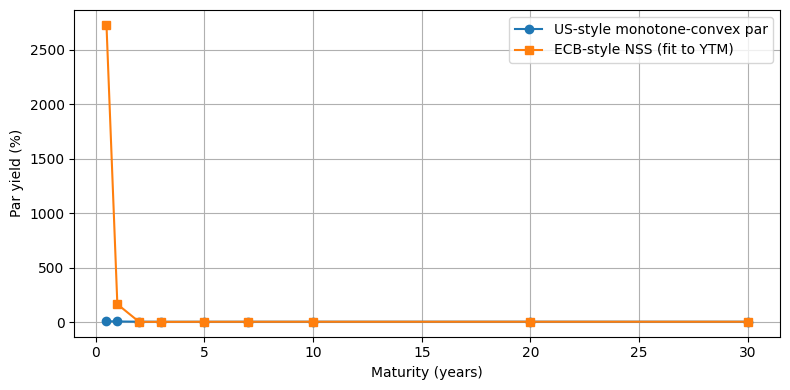

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(target_tenors, [par_us[T]*100 for T in target_tenors],
         marker="o", label="US-style monotone-convex par")
plt.plot(target_tenors, [par_ecb[T]*100 for T in target_tenors],
         marker="s", label="ECB-style NSS (fit to YTM)")
plt.xlabel("Maturity (years)")
plt.ylabel("Par yield (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 8. Analysis
Both methods start from **bond prices**, but they target and fit different objects and impose different structure, which affects local fit, smoothness, and economic interpretation. [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology)

### What is being fitted

- ECB: **Observed bond yields**  
  - Target: redemption yields (YTM) of many individual euro‑area government bonds across the curve. [ecb.europa](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/shared/pdf/technical_notes.pdf)
  - The NSS curve is estimated by minimising the sum of squared differences between **model‑implied yields** (from the NSS discount function) and these observed yields. The NSS parameters determine the zero-coupon curve. [bis](https://www.bis.org/publ/bppdf/bispap25a.pdf)
  - The forward, and par curves are then derived from the zero-coupon curve. [ecb.europa](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html)


- US Treasury: **Synthetic par curve directly**  
  - Inputs: indicative bid‑side prices (or discount rates for bills) of the on‑the‑run Treasury set. [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/yield-curve-methodology-change-information-sheet)
  - They bootstrap **instantaneous forward rates** so that these specific securities are priced without error, then apply monotone‑convex interpolation on forwards and read off the **par yield curve**. [actuarial](https://www.actuarial.news/2022/09/21/daily-treasury-par-yield-curve-rates-2/)
  - The official published object is already a par curve at standard maturities (CMTs). [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology)

### Cross‑section vs. curve type

- ECB: cross‑section of yields on many bonds  
  - Uses a **broad universe** (dozens or hundreds of bonds) spanning 3M–30Y, both coupon and zero‑coupon/STRIPS. [data.ecb.europa](https://data.ecb.europa.eu/methodology/yield-curves)
  - Each bond’s price is matched approximately (least squares), giving a curve that reflects the **average pricing** of that whole market segment.  
  - This is a **zero‑coupon (spot)** curve by construction; par rates are secondary outputs. [ecb.europa](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/shared/pdf/technical_notes.pdf)


- US Treasury: small set of on‑the‑run instruments  
  - Uses only **most recently auctioned** bills, notes and bonds at specific maturities; off‑the‑run paper is not used. [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/yield-curve-methodology-change-information-sheet)
  - These instruments are matched essentially **exactly**, then the par curve is interpolated between them.  
  - The resulting curve is **par** by design; the zero‑coupon curve is implicit via forwards. [diversification](https://diversification.com/term/zero-coupon-yield-curve)

### Model structure and flexibility

- ECB NSS (parametric):  
  - Six parameters \((\beta_0,\dots,\tau_2)\) constrain the shape: level, slope and two curvature “humps”. [bis](https://www.bis.org/publ/bppdf/bispap25a.pdf)
  - Advantages: smooth, stable over time, easy factor interpretation; but **cannot exactly match all local kinks** in market data.  
  - Fitting directly to observed YTMs avoids dependence on any prior spot/par model, but the functional form is restrictive.


- US monotone‑convex (spline on forwards):  
  - Highly **local**, shape‑preserving interpolation of bootstrapped forwards. [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology)
  - Advantages: exact pricing for inputs, preserves monotonicity/convexity in forwards, flexible around input maturities.  
  - Drawback: depends heavily on the chosen input set (on‑the‑run only) and may capture micro‑structure noise more than a smooth parametric fit.

### Practical consequences

- Short / liquid tenors:  
  - Both curves are tightly constrained by deep markets; differences will be small and reflect mainly modelling choices (NSS global smoothness vs forward‑spline local fit). [ecb.europa](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html)
- Intermediate / long tenors and gaps:  
  - ECB: NSS effectively **smooths across gaps** and noisy bonds, giving a macro‑oriented “average” term structure (useful for term premia, macro modelling, cross‑country comparisons). [ecb.europa](https://www.ecb.europa.eu/pub/pdf/scpsps/ecb.sps27.en.pdf)
  - US: the monotone‑convex curve **honours the on‑the‑run points exactly**, which is ideal for pricing/hedging around those securities, but long‑tenor behaviour between them is driven by the interpolation scheme rather than a global factor structure. [bis](https://www.bis.org/publ/bppdf/bispap25.htm)
- Dependence on synthetic yields:  
  - ECB: baseline fit is to **actual bond yields**; synthetic par/zero series are outputs, not inputs. [data.ecb.europa](https://data.ecb.europa.eu/methodology/yield-curves)
  - US: official output is par; the underlying zero/forward structure is inferred (and not directly published), but still rooted in actual prices of the on‑the‑run securities. [actuarial](https://www.actuarial.news/2022/09/21/daily-treasury-par-yield-curve-rates-2/)

In this notebook, we mimic ECB by fitting NSS to synthetic par yields from the US curve; the **real** ECB process instead fits NSS straight to market bond yields, which makes it less dependent on another model’s structure but more constrained by the cross‑section of actual traded instruments.